### Census Data

In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [2]:
d = {}

for flow in ['imports', 'exports']:
    base = f'https://api.census.gov/data/timeseries/intltrade/{flow}/hs'
    params = ['CTY_CODE', 'CTY_NAME', 'ALL_VAL_MO']
    if flow == 'imports':
        params[2] = 'GEN_VAL_MO'
    
    param = ','.join(params)
    url = f'{base}?get={param}&key={census_key}&time=from+2016-01'

    r = requests.get(url).json()

    d[flow] = r

In [4]:
pd.DataFrame(d)

ValueError: arrays must all be same length

In [1]:
import requests
import pandas as pd
import config

import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('bdew', config.plotly_key)

%matplotlib inline

In [2]:
base = 'https://api.census.gov/data/timeseries/intltrade/'
key = config.census_key
time = 'from+2016-01'

In [3]:
d = {}
for flow, param in [('exports','CTY_CODE,CTY_NAME,ALL_VAL_MO'), ('imports','CTY_CODE,CTY_NAME,GEN_VAL_MO')]:
    url = '{}{}/hs?get={}&key={}&time={}'.format(base, flow, param, key, time)
    r = requests.get(url).json()
    df = pd.DataFrame(r[1:], columns=r[0])#
    df = df[(df['CTY_CODE'].str[0] !='0') & (df['CTY_CODE'].str[1] != 'X') & (~df['CTY_NAME'].str.contains('COUNTRIES'))]
    d[flow] = df.set_index(['CTY_NAME', pd.to_datetime(df['time'])])[param[-10:]].astype(float)

In [4]:
cty_list = list(df.set_index('time').loc['2018-03']['CTY_NAME'].values)

In [5]:
df2 = pd.concat(d).unstack(level=0).div(1000000000).loc[cty_list]
# Calculate trade balance
df2['balance'] = df2['exports'] - df2['imports']
df2['imp_neg'] = 0 - df2['imports']
df1 = df2.groupby(level=0).tail(1).reset_index().set_index('CTY_NAME')
df1.columns = ['{}_lt'.format(df1.keys()[n]) for n in range(len(df1.keys()))]
df2 = df2.groupby(level=0).diff(12).groupby(level=0).tail(1).unstack()
date = df2.columns.levels[1][-1].strftime('%b %Y')
date2 = df2.columns.levels[1][-1].strftime('%b-%Y')
df2.columns = df2.columns.levels[0].values
df2 = df2.sort_values('balance').dropna()
df2 = df2.join(df1)
df2['symbol'] = ['▴'.format() if x >= 0 else '▾'.format() for x in df2['balance']]
for i, j in df2.iterrows():
    df2.loc[i,'text'] = '<b>{}</b><br>(<i>{}</i>)<br>Balance: ${:.2f}B ({}${:.2f}B)<br>Exports: ${:.2f}B<br>Imports: ${:.2f}B'.format(
        i, date, df2['balance_lt'][i], df2['symbol'][i], df2['balance'][i], df2['exports_lt'][i], df2['imports_lt'][i])
df2 = df2.head(10).append(pd.DataFrame(index=[''])).append(df2.tail(10))

C:\Users\BDew\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




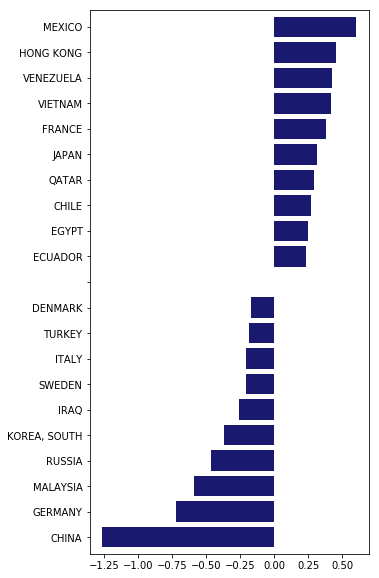

In [6]:
df2['balance'].plot(kind='barh', figsize=(5,10), color='midnightblue', width=0.8)

In [7]:
#date2 = df2.columns.levels[1][-1].strftime('%b-%Y')
df2.to_csv('trade_dynamics-goods_balance_{}.csv'.format(date2))

In [8]:
x_max = df2[['balance', 'exports', 'imp_neg']].max().max() * 1.12
x_min = df2[['balance', 'exports', 'imp_neg']].min().min() * 1.12

In [10]:
trace1 = {
    "x": df2['balance'], 
    "y": df2.index, 
    "text": df2['text'], 
    "textposition": 'middle center',
    "name": 'Balance', 
    "mode": "markers",
    "hoverinfo": "text",
    "marker": {
        "color": "rgb(255,255,255)",
        "line": {
        "color": "rgb(127, 127, 127)",
        "width": 2
        },
        "symbol": "diamond",
        "size": 12
    },
    "type": "scatter",
    "hoverinfo": "text", 
}
trace2 = {
    "x": df2['imp_neg'], 
    "y": df2.index, 
    "name": 'Imports', 
    "orientation": "h", 
    "type": "bar",
    "hoverinfo": "none",
    "marker": {
        "color": "rgb(34, 49, 240)", 
        "line": {
          "color": "rgb(8,48,107)", 
          "width": 0
    }
  }, 
}
trace3 = {
    "x": df2['exports'], 
    "y": df2.index, 
    "name": 'Exports', 
    "orientation": "h", 
    "type": "bar",
    "hoverinfo": "none",
    "marker": {
        "color": "rgb(39, 174, 96)", 
        "line": {
          "color": "rgb(8,48,107)", 
          "width": 0
    }
  }, 
}
data = Data([trace1, trace2, trace3])
layout = {
  "annotations": [
    {
      "x": -0.26, 
      "y": -0.045, 
      "font": {"color": "rgb(127, 127, 127)"}, 
      "showarrow": False, 
      "text": "Billions of USD", 
      "xref": "paper", 
      "yref": "paper"
    }, 
    {
      "x": -0.4, 
      "y": 1.09992156863, 
      "font": {"size": 18}, 
      "showarrow": False, 
      "text": "<b>Change in U.S. goods trade balance, {}</b>".format(date), 
      "xref": "paper", 
      "yref": "paper"
    }, 
    {
      "x": -0.38, 
      "y": 1.05692156863, 
      "font": {"size": 12}, 
      "showarrow": False, 
      "text": "<i>Change over same month previous year (top- and bottom-ten partners shown)</i>", 
      "xref": "paper", 
      "yref": "paper"
    }, 
    {
      "x": -0.4, 
      "y": -0.1, 
      "font": {
        "color": "rgb(127, 127, 127)", 
        "size": 14
      }, 
      "showarrow": False, 
      "text": "Source: U.S. Census Bureau", 
      "xref": "paper", 
      "yref": "paper"
    }, 
    {
      "x": 0.06, 
      "y": 0.02, 
      "arrowhead": 2, 
      "ax": 125, 
      "ay": 0, 
      "showarrow": True, 
      "text": "<b>worsened    balance</b>", 
      "xref": "paper", 
      "yref": "paper"
    }, 
    {
      "x": 1.01666666667, 
      "y": 0.02, 
      "align": "left", 
      "arrowhead": 2, 
      "ax": -57, 
      "ay": 0, 
      "showarrow": True, 
      "text": "&lt;b&gt;improved&lt;/b&gt;<br>", 
      "xref": "paper", 
      "yref": "paper"
    }
  ], 
  "autosize": False, 
  "barmode": "relative", 
  "height": 650, 
  "hovermode": "closest", 
  "legend": {
    "x": 0.70, 
    "y": 0.10, 
    "traceorder": "reversed"
  }, 
  "margin": {
    "r": 20, 
    "t": 90, 
    "b": 90, 
    "l": 150
  }, 
  "shapes": [
    {
      "line": {
        "color": "rgb(127, 127, 127)", 
        "dash": "dot", 
        "width": 3
      }, 
      "type": "line", 
      "x0": -0.35, 
      "x1": 1, 
      "xref": "paper", 
      "y0": 0.52, 
      "y1": 0.52, 
      "yref": "paper"
    }
  ], 
  "showlegend": True, 
  "title": "", 
  "width": 500, 
  "xaxis": {
    "anchor": "y", 
    "autorange": True, 
    "domain": [0, 1], 
    "fixedrange": True, 
    "position": 0, 
    "range": [x_min, x_max], 
    "showspikes": False, 
    "side": "bottom", 
    "tickfont": {"color": "rgb(127, 127, 127)"}, 
    "title": "", 
    "type": "linear"
  }, 
  "yaxis": {
    "autorange": False, 
    "range": [-1.51960784314, 20.5], 
    "showspikes": False, 
    "title": "", 
    "type": "category"
  }
}
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='Trade_Dynamics_2')

C:\Users\BDew\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


